<a href="https://colab.research.google.com/github/Dhaneshkp/DesktopAssistant/blob/main/Premium_GAN_rangetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

Everst_data=pd.read_csv(r'Everest_data.csv')
data=Everst_data
data['Attained_age']=data['Age']+data['Duration']
data['Premium_rate']=data['BasePremiumAmount']/data['BaseNARAmount']*10000
exclude_cols = ['Gender','RiskClass']
Coulmns_to_keep=['Attained_age','Premium_rate']
data=data[data['SingleOrJointType']=="Single"]
data=data[data['Gender']=="Male"]
data=data[data['RiskClass']=="NS1"]
data=data[Coulmns_to_keep]
numerical_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(include=['object']).columns
#data.iloc[4::5, 1] = np.nan
test_data=data.head(1000)
test_data


,Attained_age,Premium_rate
0,41,3.795200
2,53,9.488000
4,59,22.345600
8,49,12.331262
9,60,24.558570
...,...,...
1424,67,53.121600
1425,46,6.851740
1427,30,3.580196
1428,48,7.422906


In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

X = test_data['Attained_age'].values.reshape(-1, 1)
y = test_data['Premium_rate'].values

# Transform features for polynomial regression (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit a linear regression model to the transformed features
model = LinearRegression()
model.fit(X_poly, y)

# Print coefficients and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Use statsmodels for a more detailed summary
X_poly_sm = sm.add_constant(X_poly)  # Add a constant for the intercept term
model_sm = sm.OLS(y, X_poly_sm).fit()
print(model_sm.summary())

X_poly

Coefficients: [ 0.         -3.47052962  0.0489827 ]
Intercept: 62.41542285913964
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     2974.
Date:                Mon, 01 Jul 2024   Prob (F-statistic):               0.00
Time:                        16:14:07   Log-Likelihood:                -3271.4
No. Observations:                1000   AIC:                             6549.
Df Residuals:                     997   BIC:                             6564.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

array([[1.000e+00, 4.100e+01, 1.681e+03],
       [1.000e+00, 5.300e+01, 2.809e+03],
       [1.000e+00, 5.900e+01, 3.481e+03],
       ...,
       [1.000e+00, 3.000e+01, 9.000e+02],
       [1.000e+00, 4.800e+01, 2.304e+03],
       [1.000e+00, 3.400e+01, 1.156e+03]])

Epoch 0/25000, Loss D: 2.3822579383850098, Loss G: 261890.703125
Epoch 1000/25000, Loss D: 0.2881017327308655, Loss G: 49.211509704589844
Epoch 2000/25000, Loss D: 0.4754006266593933, Loss G: 12.08871841430664
Epoch 3000/25000, Loss D: 0.4872593283653259, Loss G: 24.752498626708984
Epoch 4000/25000, Loss D: 0.3734593391418457, Loss G: 20.273454666137695
Epoch 5000/25000, Loss D: 0.40808403491973877, Loss G: 20.557720184326172
Epoch 6000/25000, Loss D: 0.44017839431762695, Loss G: 23.39396858215332
Epoch 7000/25000, Loss D: 0.37877869606018066, Loss G: 28.868610382080078
Epoch 8000/25000, Loss D: 0.4218721091747284, Loss G: 25.096900939941406
Epoch 9000/25000, Loss D: 0.47637051343917847, Loss G: 19.983665466308594
Epoch 10000/25000, Loss D: 0.4244113564491272, Loss G: 11.783330917358398
Epoch 11000/25000, Loss D: 0.45695146918296814, Loss G: 13.645419120788574
Epoch 12000/25000, Loss D: 0.43685609102249146, Loss G: 13.219733238220215
Epoch 13000/25000, Loss D: 0.439516544342041, Loss G

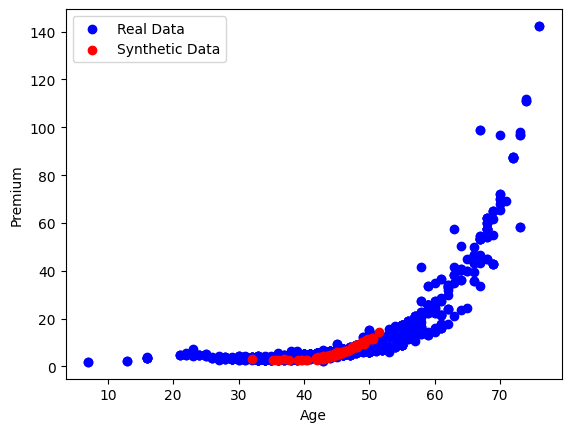

In [82]:
import torch

import torch.nn as nn

import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

# Define the Generator

class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim, age_min, age_max):  # Add age range parameters
        super(Generator, self).__init__()
        self.age_min = age_min
        self.age_max = age_max
        self.model = nn.Sequential(

            nn.Linear(noise_dim, 128),

            nn.ReLU(),

            nn.Linear(128, 128),

            nn.ReLU(),

            nn.Linear(128, output_dim)

        )



    def forward(self, x):
        output = self.model(x)

        # Normalize 'age' to be within the desired range
        output[:, 0] = (output[:, 0] + 2) #1) #/ 2  # Scale to [0, 1]
        output[:, 0] = output[:, 0] * (self.age_max*1- self.age_min*1) + self.age_min*1 # Scale and shift to [age_min, age_max]

        return output

# Define the Discriminator

class Discriminator(nn.Module):

    def __init__(self, input_dim):

        super(Discriminator, self).__init__()

        self.model = nn.Sequential(

            nn.Linear(input_dim, 128),

            nn.ReLU(),

            nn.Linear(128, 128),

            nn.ReLU(),

            nn.Linear(128, 1),

            nn.Sigmoid()

        )



    def forward(self, x):

        return self.model(x)

# Generate real data

def get_real_data(num_samples):

    # Simulating some real data for demonstration

    ages = np.random.uniform(18, 70, size=num_samples)

    #premiums = -37.1802       + ages * 1.0962   + np.random.normal(0, 10, size=num_samples)  # Example regression line

    data = test_data.sample(n=num_samples, replace=True).values #np.column_stack((ages, premiums))
    return torch.tensor(data, dtype=torch.float32)

# Hyperparameters

noise_dim = 1000

feature_dim = 1  # 'age' as feature

predictor_dim = 1  # 'premium' as predictor

num_epochs = 25000

batch_size = 64

# Models
age_min = test_data['Attained_age'].min()
age_max = test_data['Attained_age'].max()
generator = Generator(noise_dim, feature_dim + predictor_dim,age_min, age_max)

discriminator = Discriminator(feature_dim + predictor_dim)

# Optimizers

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)

optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss functions

adversarial_loss = nn.BCELoss()

regression_loss = nn.MSELoss()

# Training

for epoch in range(num_epochs):

    # Train Discriminator

    real_data = get_real_data(batch_size)



    # Real data

    real_labels = torch.ones(batch_size, 1)

    output_real = discriminator(real_data)

    loss_real = adversarial_loss(output_real, real_labels)



    # Fake data
    mean = 0 # Desired mean
    std = 1.5   # Desired standard deviation

    noise = torch.randn(batch_size, noise_dim) * std + mean
    #noise = torch.randn(batch_size, noise_dim)

    fake_data = generator(noise)

    fake_labels = torch.zeros(batch_size, 1)

    output_fake = discriminator(fake_data.detach())

    loss_fake = adversarial_loss(output_fake, fake_labels)



    # Total discriminator loss

    loss_D = (loss_real + loss_fake) / 2



    optimizer_D.zero_grad()

    loss_D.backward()

    optimizer_D.step()



    # Train Generator

    output_fake = discriminator(fake_data)

    loss_G_adv = adversarial_loss(output_fake, real_labels)



    # Regression constraint

    real_features = real_data[:, 0]  # 'age'

    real_predictor = real_data[:, 1]  # 'premium'

    fake_features = fake_data[:, 0]

    fake_predictor = fake_data[:, 1]



    # For simplicity, assume a linear regression model with known coefficients

    #regression_model = lambda x: -37.1802       + x * 1.0962
    regression_model = lambda x:  62.4154     + x * -3.4705 + (x**2) * 0.0489827
    predicted_predictor = regression_model(fake_features)

    loss_G_reg = regression_loss(predicted_predictor, fake_predictor)

    # Feature Matching Loss
    real_features = discriminator.model[:-1](real_data)  # Extract features from real data
    fake_features = discriminator.model[:-1](fake_data)  # Extract features from fake data
    loss_G_feat = regression_loss(real_features.mean(0), fake_features.mean(0))  # Calculate feature matching loss

    # Total generator loss
    loss_G = loss_G_adv + 0.5 * loss_G_reg + 0.1 * loss_G_feat  # Adjust weights as needed

    # Total generator loss

    #loss_G = loss_G_adv + loss_G_reg*2



    optimizer_G.zero_grad()

    loss_G.backward()

    optimizer_G.step()



    if epoch % 1000 == 0:

        print(f"Epoch {epoch}/{num_epochs}, Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

# Generate some synthetic data

mean = 0  # Desired mean for the noise
std = 1  # Desired standard deviation for the noise

noise = torch.randn(100, noise_dim) * std + mean

#noise = torch.randn(100, noise_dim)

synthetic_data = generator(noise).detach().numpy()

# Plot real vs synthetic data

real_data = get_real_data(1000).numpy()

plt.scatter(real_data[:, 0], real_data[:, 1], color='blue', label='Real Data')

plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], color='red', label='Synthetic Data')

plt.xlabel('Age')

plt.ylabel('Premium')

plt.legend()

plt.show()

In [83]:
  synthetic_df  = pd.DataFrame(synthetic_data, columns=['Attained_age', 'Premium_rate'])


In [84]:
synthetic_df

,Attained_age,Premium_rate
0,49.146919,9.459237
1,44.597263,5.000545
2,42.639660,3.530016
3,46.142479,6.201826
4,44.205143,4.581580
...,...,...
95,43.800007,4.038430
96,43.472584,3.545674
97,42.955582,3.911024
98,47.185753,7.413687


In [85]:
# prompt: Using dataframe synthetic_df: fit regression

import statsmodels.api as sm

# Fit a linear regression model

X = synthetic_df['Attained_age'].values.reshape(-1, 1)
y = synthetic_df['Premium_rate'].values

# Transform features for polynomial regression (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit a linear regression model to the transformed features
model = LinearRegression()
model.fit(X_poly, y)

# Print coefficients and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Use statsmodels for a more detailed summary
X_poly_sm = sm.add_constant(X_poly)  # Add a constant for the intercept term
model_sm = sm.OLS(y, X_poly_sm).fit()
print(model_sm.summary())


Coefficients: [ 0.         -4.7338147   0.06233406]
Intercept: 92.0598
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2607.
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           4.84e-85
Time:                        18:03:22   Log-Likelihood:                -41.094
No. Observations:                 100   AIC:                             88.19
Df Residuals:                      97   BIC:                             96.00
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

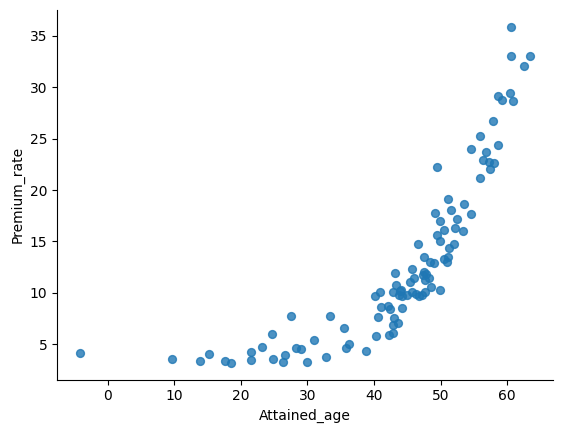

In [101]:
from matplotlib import pyplot as plt
synthetic_df.plot(kind='scatter', x='Attained_age', y='Premium_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

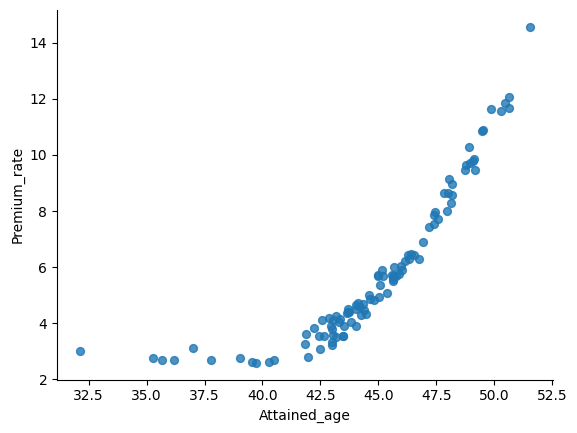

In [86]:
from matplotlib import pyplot as plt
synthetic_df.plot(kind='scatter', x='Attained_age', y='Premium_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

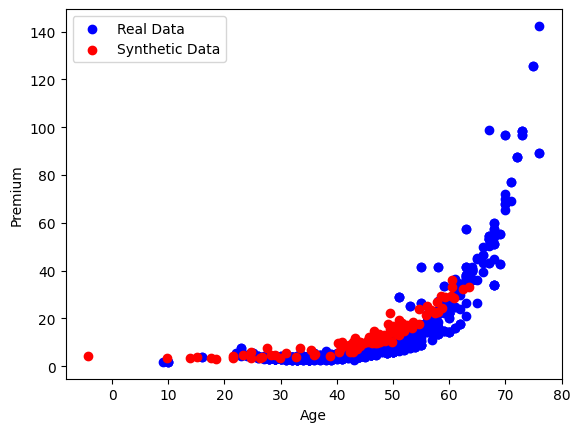

In [97]:

mean = 1  # Desired mean for the noise
std = 3  # Desired standard deviation for the noise

noise = torch.randn(100, noise_dim) * std + mean

#noise = torch.randn(100, noise_dim)

synthetic_data = generator(noise).detach().numpy()

# Plot real vs synthetic data

real_data = get_real_data(1000).numpy()

plt.scatter(real_data[:, 0], real_data[:, 1], color='blue', label='Real Data')

plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], color='red', label='Synthetic Data')

plt.xlabel('Age')

plt.ylabel('Premium')

plt.legend()

plt.show()

In [99]:
import statsmodels.api as sm

# Fit a linear regression model
synthetic_df  = pd.DataFrame(synthetic_data, columns=['Attained_age', 'Premium_rate'])

X = synthetic_df['Attained_age'].values.reshape(-1, 1)
y = synthetic_df['Premium_rate'].values

# Transform features for polynomial regression (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit a linear regression model to the transformed features
model = LinearRegression()
model.fit(X_poly, y)

# Print coefficients and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Use statsmodels for a more detailed summary
X_poly_sm = sm.add_constant(X_poly)  # Add a constant for the intercept term
model_sm = sm.OLS(y, X_poly_sm).fit()
print(model_sm.summary())


Coefficients: [ 0.         -0.7059543   0.01669538]
Intercept: 9.148931
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     422.1
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           1.37e-48
Time:                        18:06:50   Log-Likelihood:                -236.59
No. Observations:                 100   AIC:                             479.2
Df Residuals:                      97   BIC:                             487.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

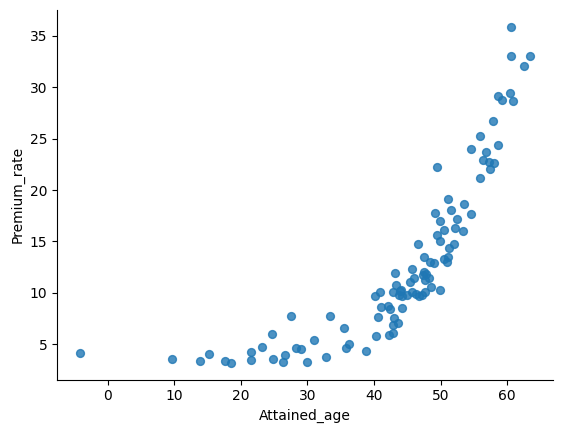

In [100]:
from matplotlib import pyplot as plt
synthetic_df.plot(kind='scatter', x='Attained_age', y='Premium_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)